# PotentioDynamic Scattering Microscopy (PDSM)

## Electric current through the liquid
 
Author: ``Sanli Faez (s.faez@uu.nl)``

last update: 8/3/2018

The main use of this notebook is to compare the current measured with an oscilloscope with the potentiodynamic contrast measured with dark-field scattering.


In [3]:
# load necessary modules and libraries
import numpy as np
import matplotlib.pyplot as plt


2482 datapoints with time step 0.0010000000000000009 seconds


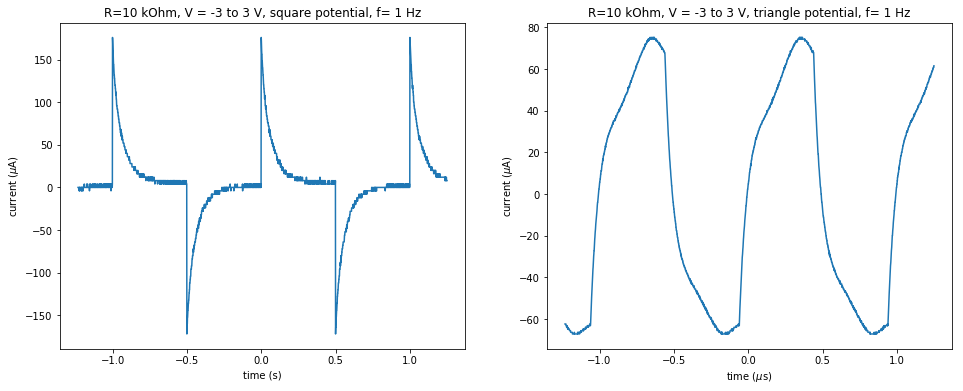

In [10]:
# import the current measured on the oscilloscope
fdir = r'/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/2019-04-18-GNP_ITO_flowcell/'
mlabel = '_2mM_NaCl'
fext = '.CSV'

fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
mfile = 'TEK0003.CSV'
fpath = fdir + mfile
dat = np.genfromtxt(fpath, skip_header = 18, delimiter = ',')
amp = dat.T[4] * 100 #convert voltage to current in microampre 
tim = dat.T[3]
ntim = tim.size
dt = np.mean(tim[1:101]-tim[0:100])
print(f"{ntim} datapoints with time step {dt} seconds")
ax1.plot(tim, amp)
plt.xlabel(r"time (s)")
plt.ylabel(r"current ($\mu$A)")
#ax1.text(0.03,0.9, mfile + mlabel , transform=ax1.transAxes, fontsize=14, color = 'blue', va='top')
plt.title(f"R=10 kOhm, V = -3 to 3 V, square potential, f= 1 Hz")

ax2 = plt.subplot(122)
mfile = 'TEK0002.CSV'
fpath = fdir + mfile
dat = np.genfromtxt(fpath, skip_header = 18, delimiter = ',')
amp = dat.T[4] * 100 #convert voltage to current in microampre 
tim = dat.T[3]
ax2.plot(tim, amp)
plt.xlabel(r"time ($\mu$s)")
plt.ylabel(r"current ($\mu$A)")
#ax2.text(0.4,0.7, mfile + mlabel, transform=ax2.transAxes, fontsize=14, color = 'blue', va='top')
plt.title(f"R=10 kOhm, V = -3 to 3 V, triangle potential, f= 1 Hz")

output = fdir + mfile.strip(fext) + mlabel + '.png'
fig.savefig(output)

decay time is 9.661305106917842e-07 seconds


Text(0,0.5,'current ($\\mu$A)')

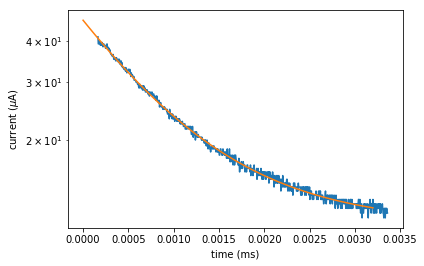

In [27]:
# isolate a peak and fit an exponential

from scipy.optimize import curve_fit
def exp_func(x, a, b, c):
    return a*np.exp(-x/b)+c


ntpeak = 800
stim = np.argmax(amp)
#print(stim)
amp_sel = amp[stim:stim+ntpeak]
tim_sel = tim[stim:stim+ntpeak]


popt, pcov = curve_fit(exp_func, tim_sel, amp_sel, p0=(100, 2e-6, 0))

print(f"decay time is {popt[1]} seconds")
xx = np.linspace(0, ntpeak)*dt
yy = exp_func(xx, *popt)

plt.semilogy(tim_sel*1000, amp_sel)
plt.semilogy(xx*1000, yy)
plt.xlabel(r"time (ms)")
plt.ylabel(r"current ($\mu$A)")
#ax1.text(0.03,0.9, mfile + mlabel , transform=ax1.transAxes, fontsize=14, color = 'blue', va='top')
#plt.title(f"Current through R=10 kOhm for Vpeak=2.8 V, square potential f= 3 Hz")

In [ ]:
from PDSM_func import AvgWaveForm as awf

mfile = 'NaCl_2mM_vpp1p6corners450x150x550x284_spots.npy'

spots = np.load(fdir+mfile)
nf = np.size(spots,1)
#nf = 2000
nspots = np.size(spots,0)
print(f"{nspots} spots traced in the region" )

# measurement info to be filled from the lab-journal
vpp = 2.8# Note: waveform amplitude goes from -vpp + vbase to vpp + vbase
real_period = 0.33 #The applied waveform period in sec
vbase = 0.0
wf = "square" # or "square" or "sine" ##use this syntax
nper_plot = 5

# use a reference spot to find the frequency and phase of the waveform, good ref spots are from ITO shiny regions
ref_spot = 1
ref_signal = spots[ref_spot,:nf]
ref_avg = np.mean(spots[ref_spot,:nf])
lag_correction = 0

wf_period, wf_lag = awf.find_period_minfit(ref_signal, guess=100, show_plot = True)
print(wf_period, wf_lag)
#wf_period = 109
wf_lag = wf_lag + lag_correction
halfper = int(wf_period/2)
applied_wf = awf.square_wf(nf, wf_period, wf_lag, vpp)
applied_wf_single = awf.square_wf(int(wf_period), wf_period, wf_lag, vpp)

ref_signal_nomean = (ref_signal - np.mean(ref_signal))/ref_avg
ref_signal_filtered = awf.fft_flat(ref_signal, wf_period)/ref_avg
ref_signal_single_period = awf.avg_single_period(ref_signal_filtered, wf_period, wf_lag)
taxis = real_period * np.arange(int(nper_plot*wf_period))/ wf_period

In [ ]:
###Plotting the change of intensity over the sequence
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
color = 'tab:green'
#ax1.plot(ref_signal_nomean[:int(nper_plot*wf_period)])

plt.title("Intensity of a single spot")
ax1.set_xlabel('time (Seconds)')
ax1.set_ylabel('applied potential (Volts)', color=color)  # we already handled the x-label with ax1
ax1.plot(taxis, applied_wf[:int(nper_plot*wf_period)], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.plot(taxis, ref_signal_filtered[:int(nper_plot*wf_period)], color=color)
ax2.set_ylabel('relative differential intensity, dI/I')

ax3 = plt.subplot(122)
ax3.set_xlabel('time (Seconds)')
ax3.set_ylabel('applied potential (Volts)', color=color)  # we already handled the x-label with ax1
ax3.plot(applied_wf_single, color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.title("Intensity of a single spot")

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax4.plot(ref_signal_single_period, color=color)
ax4.set_ylabel('relative differential intensity, dI/I')


plt.show()